In [16]:
!pip install tensorboard torcheval pandas regex emoji nltk matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 122.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 98.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 28.9 MB/s eta 0:00:00


In [23]:
# Torch loads
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torcheval.metrics.functional import binary_f1_score

# Non-Torch Loads
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta

#Cleaning Loads
import regex as re
import emoji
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import requests

#Visualization
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [18]:
train_path = "nlp-getting-started/train.csv"
test_path = "nlp-getting-started/test.csv"
train = pd.read_csv(train_path, header = 0)
train = train.drop(labels = ["keyword", "location", "id"], axis = 1)
test = pd.read_csv(test_path, header = 0)
test = test.drop(labels = ["keyword", "location"], axis = 1)
print("train")
print(train.head())
print("test")
print(test.head())

train
                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1
test
   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


# EDA
The dataset has 57% non-disaster tweets, and 43% Disaster tweets.  There are 31924 unique words.  This will drive my tuning the vectorization of the model.

In [19]:
train['target'].describe()

count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

In [20]:
unique_words = set()
for text in train["text"]:
    unique_words.update(text.split())
print(len(unique_words))

31924


# Cleaning
Standard tweet cleaning.  Cleaning found at:
https://stackoverflow.com/questions/64719706/cleaning-twitter-data-pandas-python

# Tokenizatin
I tolkenized the tweets in preparation to convert to tensors for embedding.


In [21]:
# Thank you Chatgpt for this
def download_file_from_github(url):
    """Download a file from a GitHub URL and return its contents as a list of lines."""
    response = requests.get(url)
    if response.status_code == 200:
        lines = response.text.splitlines()  # Split the content into lines
        return lines  # You could change this to `set(lines)` if you need a set instead of a list
    else:
        raise Exception(f"Failed to download file: {response.status_code}")

In [24]:
vocab = nltk.lm.Vocabulary()
output = pd.DataFrame()
stop_words = download_file_from_github("https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/raw/stop-words-english1.txt")
contractions = download_file_from_github("https://gist.githubusercontent.com/J3RN/ed7b420a6ea1d5bd6d06/raw/acda66b325a2b4d7282fb602a7551912cdc81e74/contractions.txt")
def cleaning(line):
    tweet = line['text']
    tweet = tweet.lower()
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = emoji.replace_emoji(tweet, '') #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = re.sub(r'[^a-z]', ' ', tweet) # Strip all symbols and replace with +
    tweet = re.sub(r'\b\w{1,2}\b+', '', tweet) #get rid of all words <= 2 characters
    #Tolkenize the Text
    word_tokens = word_tokenize(tweet)
    word_tokens = [w for w in word_tokens if not w in stop_words]
    word_tokens = [w for w in word_tokens if not w in contractions]
    #tknzr = nltk.tokenize.casual.TweetTokenizer(preserve_case = False, strip_handles = True, reduce_len = True)
    #tweet = tknzr.tokenize(tweet)
    vocab.update(word_tokens)
    return word_tokens 
train['cleaned_text'] = train.apply(cleaning, axis = 1)
train['text'] = train['cleaned_text']
train = train.drop(labels = ['cleaned_text'], axis = 1)
test['cleaned_text'] = test.apply(cleaning, axis = 1)
test['text'] = test['cleaned_text']
test = test.drop(labels = ['cleaned_text'], axis = 1)

In [25]:
print(train.head(20))
zero_length_lists = train[train['text'].apply(lambda x: len(x) == 0)]
print("Rows processed with 0 remaining words")
print(zero_length_lists)

                                                 text  target
0         [deeds, reason, earthquake, allah, forgive]       1
1                 [forest, fire, ronge, sask, canada]       1
2   [residents, asked, shelter, place, notified, o...       1
3   [people, receive, wildfires, evacuation, order...       1
4   [photo, ruby, alaska, smoke, wildfires, pours,...       1
5   [rockyfire, update, california, hwy, closed, d...       1
6   [flood, disaster, heavy, rain, flash, flooding...       1
7                            [top, hill, fire, woods]       1
8   [emergency, evacuation, happening, building, s...       1
9                     [afraid, tornado, coming, area]       1
10                         [people, died, heat, wave]       1
11  [haha, south, tampa, flooded, hah, wait, live,...       1
12  [raining, flooding, florida, tampabay, tampa, ...       1
13              [flood, bago, myanmar, arrived, bago]       1
14  [damage, school, bus, multi, car, crash, break...       1
15      

# Additional EDA.  
Thats intresting.  All the items that are all stopwords are going to be no an emergency.

In [26]:
train = train[train['text'].apply(lambda x: len(x) != 0)]

In [27]:
# Split the data into train and test sets
train_dat = train.sample(frac = .9)
test_dat = train.drop(train_dat.index)

In [28]:
vocab_dict = {}
for item in list(vocab):
    vocab_dict[item] = vocab[item]
print(len(vocab_dict))

16548


# Vectorizing
I used pytorchs internal vectorizer to vectorize the text.  I


In [29]:
# Dataset Importing from https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

#tokenize the text for tensor load
def tokenize(text):
    # Your tokenizer logic here
    return [vocab[token] for token in text.split()]

class CustomTextDataset(Dataset):
    def __init__(self, data,vocab, transform=None, target_transform=None):
        self.data = data
        self.vocab = vocab
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tweet = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        tokenized_tweet = [self.vocab.get(token, 0) for token in tweet]  # Tokenize and handle unknown tokens
        tweet_tensor  = torch.tensor(tokenized_tweet, dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.float)
        
        if self.transform:
            tweet_tensor = self.transform(tweet_tensor)
        if self.target_transform:
            label_tensor = self.target_transform(label_tensor)

        return tweet_tensor, label_tensor

def collate_batch(batch):
    label_list, text_list = [], []
    for (_text, _label) in batch:
        label_list.append(_label)
        text_list.append(_text.clone().detach())
    return pad_sequence(text_list, batch_first=True), torch.tensor(label_list, dtype=torch.float)

# Creating training and validation datasets
training_set = CustomTextDataset(train_dat, vocab_dict)
validation_set = CustomTextDataset(test_dat, vocab_dict)
#test set = CustomTextDataset(val_dat, vocab)

# Creating data loaders
training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True, collate_fn=collate_batch)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=False, collate_fn=collate_batch)


# Model approach
I'm choosing to use a RNN were I only select the last value as the output, so many in and 1 out.  

In [30]:


def train_one_epoch(epoch_index, model,training_loader, loss_fn, optimizer, tb_writer):
    running_loss = 0.
    last_loss = 0.
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs_cuda = inputs.to('cuda')
        labels_cuda = labels.to('cuda')

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs_cuda)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels_cuda)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 1000 # loss per batch
            #print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0

    return last_loss

# test execution
#model = Tweets(vocab_size=30000, embedding_dim =1024).to('cuda')
#loss_fn = nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#tb_writer = SummaryWriter('logs')
#train_one_epoch(1,model, training_loader, loss_fn, optimizer, tb_writer)
#tb_writer.close()

output_data = pd.DataFrame()

Ok, .68 validation loss.  Thats not good.  I'm going to run a optomizer to try and find the optimal variables.


In [31]:
# Plot the DataFrame
def plot_vals(df, title, result_text):
    #df = df.set_index('epoch')
    df = df.sort_index() 
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
    plt.plot(df['epoch'], df['val_f1'], label='Validation F1')
    plt.title(title)
    plt.text(3, .25, result_text)
    plt.xlabel('Epoch')
    plt.ylabel('Loss/F1')
    plt.legend()
    plt.show()

def multi_plot_vals(df, title, result_text, run_range):
    fig, axes = plt.subplots(len(run_range), 1, figsize=(10, 6 * len(run_range)), sharex=True)
    
    if len(run_range) == 1:
        axes = [axes]  # Make it iterable if there's only one plot
    
    for ax, run in zip(axes, run_range):
        data = df[df['run'] == run]
        ax.plot(data['epoch'], data['val_loss'], label='Validation Loss')
        ax.plot(data['epoch'], data['val_f1'], label='Validation F1')
        ax.set_title(f"{title} (Run {run})")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss/F1')
        ax.legend()
    
    plt.suptitle(title)
    fig.text(0.5, 0.02, result_text, ha='center')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [32]:
best_global_vloss = 1
output_data = pd.DataFrame(columns = ["run", "train_loss", "val_loss", "val_f1"])
# Initializing in a separate cell so we can easily add more epochs to the same run
def run_model(model, epochs, output_data, run_num):
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    
    timestamp = datetime.now(timezone.utc).strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
    
    epoch_number = 0
    
    best_vloss = 1.
    best_vf1 = 0
    best_vf1_count = 0
    
    for epoch in range(epochs):
        #print('EPOCH {}:'.format(epoch_number + 1))
    
        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number,model, training_loader, loss_fn, optimizer, writer)
        
    
        running_vloss = 0.0
        running_vf1 = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                vinputs_cuda = vinputs.to('cuda')
                vlabels_cuda = vlabels.to('cuda')
                voutputs = model(vinputs_cuda)
                vloss = loss_fn(voutputs, vlabels_cuda)
                vf1 = binary_f1_score(voutputs, vlabels_cuda)
                running_vloss += vloss
                running_vf1 += vf1.item()
                
        avg_vloss = running_vloss / (i + 1)
        avg_vf1 = running_vf1 / (i + 1)
        #print('LOSS train {} valid {} Binary F1 {}'.format(avg_loss, avg_vloss, avg_vf1))
        
        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss},
                        epoch_number + 1)
        writer.flush()
        new_row = {
            "run": run_num,
            "epoch": epoch_number,
            "train_loss": avg_loss,
            "val_loss": avg_vloss.item(),
            "val_f1": avg_vf1
        }
        output_data = pd.concat([output_data, pd.DataFrame([new_row])], ignore_index = True)
        # Track best performance, and save the model's state
        global best_global_vloss
        global best_model_params
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
        if avg_vloss < best_global_vloss:
            model_path = 'best_model.model'
            best_global_vloss = avg_vloss
            torch.save(model.state_dict(), model_path)
        #Calculate Best VAccuracy
        if best_vf1 < avg_vf1:
            best_vf1 = avg_vf1
            best_vf1_count = 0
        else: 
            best_vf1_count += 1

        #Cutoff the model if the VACC goest down after 2 cycles
        #if best_vacc_count == 3:
            #break
        
        epoch_number += 1
    result_text = f'Best Validation Loss: {best_vloss}  Best Validation F1: {best_vf1}'


    torch.cuda.empty_cache()
    return (output_data, result_text)

In [33]:
# Initial Setup
best_model_params = []
class Tweets_RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, nonlinearity):
        super(Tweets_RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn_layer = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers,
                                nonlinearity=nonlinearity, bias=True, bidirectional=True)
        # Add TanH Layer
        
        self.dropout = nn.Dropout(p=.75)
        #self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size * 2, 1)
        # Step Down linear layers?
        #self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, input_text):
        # Assuming input_text is already a LongTensor that has been prepared outside the model
        embedded = self.embedding(input_text)
        rnn_output, _ = self.rnn_layer(embedded)
        dropout = self.dropout(rnn_output)
        output = dropout[:, :, :]
        linear = self.linear(output)
        final_output = linear.mean(dim=1)
        #print(final_output.shape)
        return final_output.squeeze()  # Squeeze to remove the extra dimension


In [17]:

run_num = 1
embedding_dim = 64
hidden_size = 512
num_layers = 1
nonlinearity = 'relu'
#
model = Tweets_RNN(vocab_size=len(vocab_dict), embedding_dim = embedding_dim,
                   hidden_size = hidden_size, num_layers= num_layers,
                   nonlinearity = nonlinearity
                  ).to('cuda')


output_data, result_text = run_model(epochs = 40, model = model, 
                output_data = output_data,
                run_num = run_num)


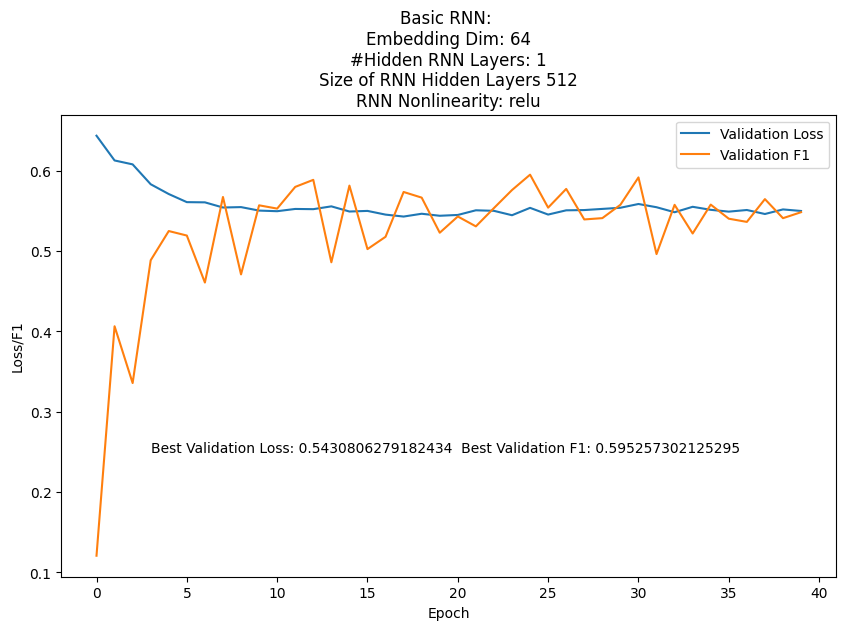

In [18]:
title = (f"Basic RNN: \nEmbedding Dim: {embedding_dim}\n"
f"#Hidden RNN Layers: {num_layers}\n"
f"Size of RNN Hidden Layers {hidden_size}\n"
f"RNN Nonlinearity: {nonlinearity}")

plot_vals(output_data[output_data['run'] == run_num], title, result_text)

In [19]:
class Tweets_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, bias, num_layers, dropout):
        super(Tweets_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, 
                                  num_layers=num_layers,bias = True,
                                  bidirectional=True, dropout = dropout)
        # Add TanH Layer
        
        self.dropout = nn.Dropout(p=.75)
        #self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size * 2, 1)
        # Step Down linear layers?
        #self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, input_text):
        # Assuming input_text is already a LongTensor that has been prepared outside the model
        embedded = self.embedding(input_text)
        lstm_output, _ = self.lstm_layer(embedded)
        dropout = self.dropout(lstm_output)
        output = dropout[:, :, :]
        linear = self.linear(output)
        final_output = linear.mean(dim=1)
        #print(final_output.shape)
        return final_output.squeeze()  # Squeeze to remove the extra dimension

In [20]:

run_num = 2
#embedding_dim = 256
#hidden_size = 512
#num_layers = 1

model = Tweets_LSTM(vocab_size=len(vocab_dict), 
                    embedding_dim = embedding_dim,
                    hidden_size = hidden_size, 
                    num_layers= num_layers, 
                    dropout = 0.5, bias = True
                  ).to('cuda')

output_data, result_text = run_model(epochs = 40, model = model, 
                output_data = output_data,
                run_num = run_num)


C:\Users\isaac\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


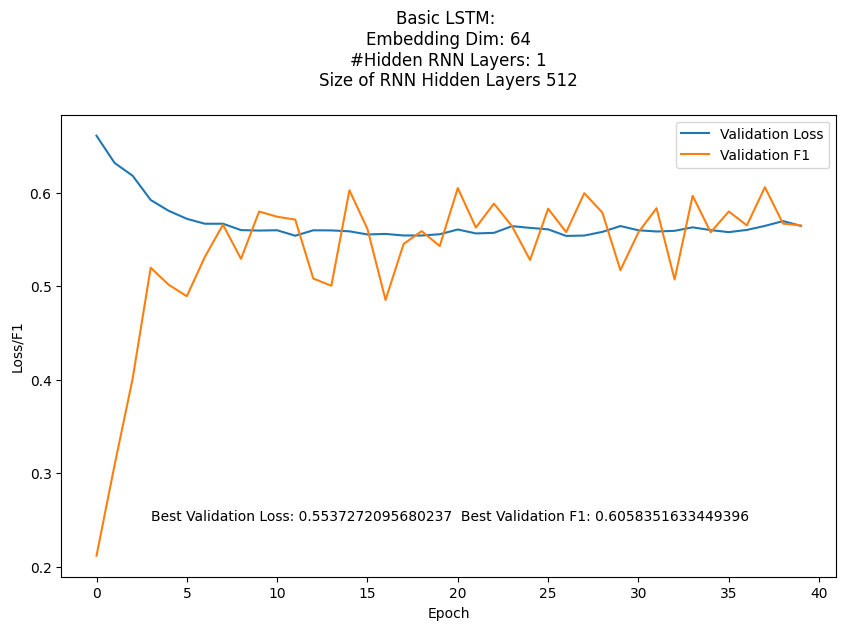

In [21]:
title = (f"Basic LSTM: \nEmbedding Dim: {embedding_dim}\n"
f"#Hidden RNN Layers: {num_layers}\n"
f"Size of RNN Hidden Layers {hidden_size}\n")

plot_vals(output_data[output_data['run'] == run_num], title, result_text)

In [22]:
class Tweets_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, bias, num_layers, dropout):
        super(Tweets_GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.GRU_layer = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, 
                                  num_layers=num_layers,bias = True,
                                  bidirectional=True, dropout = dropout)
        # Add TanH Layer
        
        self.dropout = nn.Dropout(p=.75)
        #self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size * 2, 1)
        # Step Down linear layers?
        #self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, input_text):
        # Assuming input_text is already a LongTensor that has been prepared outside the model
        embedded = self.embedding(input_text)
        gru_output, _ = self.GRU_layer(embedded)
        dropout = self.dropout(gru_output)
        output = dropout[:, :, :]
        linear = self.linear(output)
        final_output = linear.mean(dim=1)
        #print(final_output.shape)
        return final_output.squeeze()  # Squeeze to remove the extra dimension

In [23]:
run_num = 3
#embedding_dim = 32
#hidden_size = 32
#num_layers = 1

model = Tweets_GRU(vocab_size=len(vocab_dict), 
                    embedding_dim = embedding_dim,
                    hidden_size = hidden_size, 
                    num_layers= num_layers, 
                    dropout = 0.5, bias = True
                  ).to('cuda')

title = f"Basic GRU: \nEmbedding Dim: {embedding_dim}\n"
f"#Hidden RNN Layers: {num_layers}\n"
f"Size of RNN Hidden Layers {hidden_size}\n"
f"RNN Nonlinearity: {nonlinearity}"

output_data, result_text = run_model(epochs = 40, model = model, 
                output_data = output_data,
                run_num = run_num)


C:\Users\isaac\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


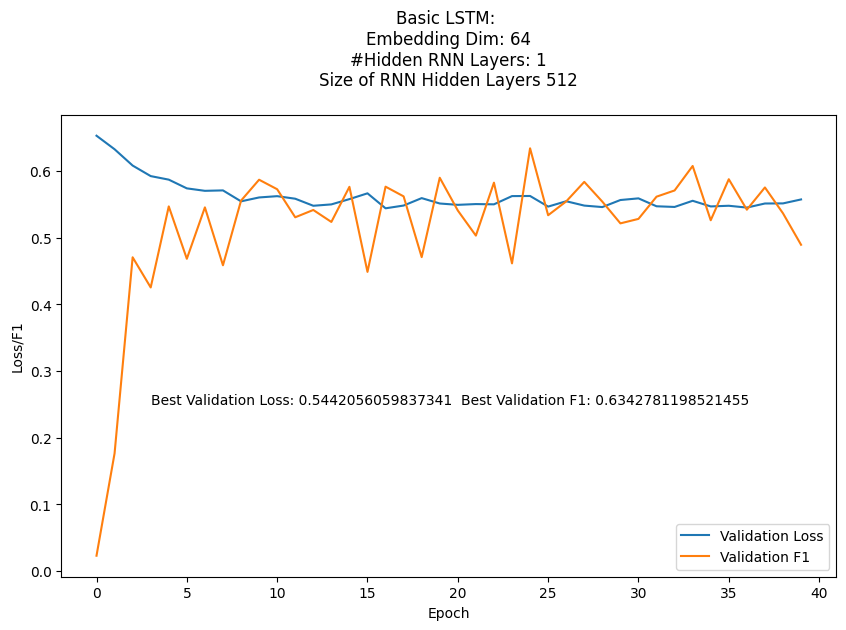

In [24]:
title = (f"Basic GRU: \nEmbedding Dim: {embedding_dim}\n"
f"#Hidden RNN Layers: {num_layers}\n"
f"Size of RNN Hidden Layers {hidden_size}\n")
plot_vals(output_data[output_data['run'] == run_num], title, result_text)

# Initial Results
I will continue with the RNN. The similarity of the results leads me to believe that there could be some flaws with my algorithim. 
I will try tuning the number of hidden layers first, then the other variables


In [28]:
run_num = 4
embedding_dim = 64
hidden_size = 512
num_layers = 2

model = Tweets_GRU(vocab_size=len(vocab_dict), 
                    embedding_dim = embedding_dim,
                    hidden_size = hidden_size, 
                    num_layers= num_layers, 
                    dropout = 0.5, bias = True
                  ).to('cuda')


output_data, result_text = run_model(epochs = 40, model = model, 
                output_data = output_data,
                run_num = run_num)

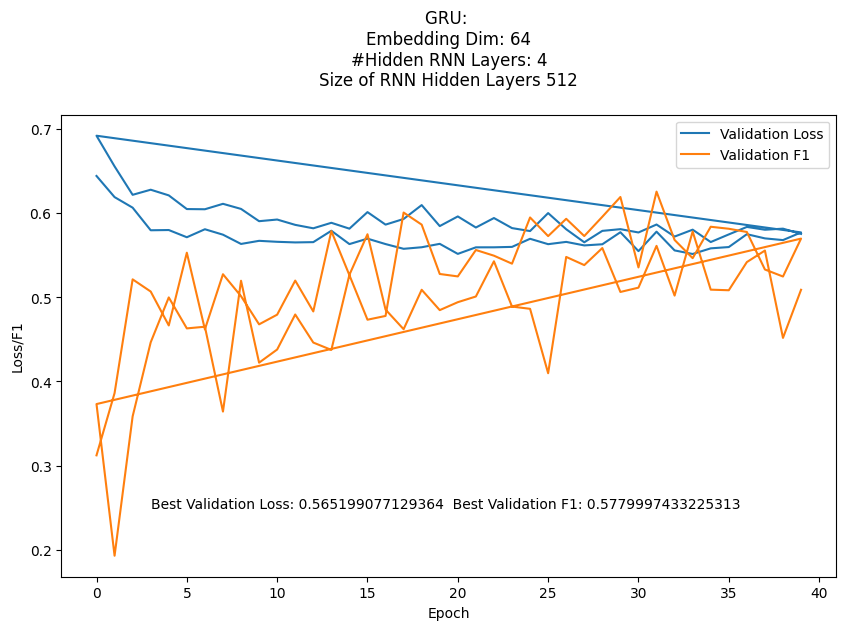

In [29]:
title = (f"GRU: \nEmbedding Dim: {embedding_dim}\n"
f"#Hidden RNN Layers: {num_layers}\n"
f"Size of RNN Hidden Layers {hidden_size}\n")
plot_vals(output_data[output_data['run'] == run_num], title, result_text)

# Results of increasing layers
This is not an improvement.  I'll try tuning the embedding dim and hidden layer size.

# Redefining the GRU class.
As I found that I only need 1 layer ATM, the dropout layer causes an error I want to get rid of.

### Note
I wont graph all of them, I'll just print the overall results of each run.

In [36]:
class Tweets_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, bias, num_layers, dropout):
        super(Tweets_GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.GRU_layer = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, 
                                  num_layers=num_layers,bias = True,
                                  bidirectional=True)
        # Add TanH Layer
        
        self.dropout = nn.Dropout(p=.75)
        #self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size * 2, 1)
        # Step Down linear layers?
        #self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, input_text):
        # Assuming input_text is already a LongTensor that has been prepared outside the model
        embedded = self.embedding(input_text)
        gru_output, _ = self.GRU_layer(embedded)
        dropout = self.dropout(gru_output)
        output = dropout[:, :, :]
        linear = self.linear(output)
        final_output = linear.mean(dim=1)
        #print(final_output.shape)
        return final_output.squeeze()  # Squeeze to remove the extra dimension

In [39]:
run_num = 5
num_layers = 1
embedding_dim_list = [32,64,128,256]
hidden_size_list = [32,64,128,256,512,1024]
for embedding_dim in embedding_dim_list:
    for hidden_size in hidden_size_list:
        model = Tweets_GRU(vocab_size=len(vocab_dict), 
                    embedding_dim = embedding_dim,
                    hidden_size = hidden_size, 
                    num_layers= num_layers, 
                    dropout = 0.5, bias = True
                  ).to('cuda')

        output_data, result_text = run_model(epochs = 40, 
                                            model = model, 
                                            output_data = output_data,
                                            run_num = run_num)
        print(f'Embedding_dim: {embedding_dim}  '
              f'Hidden Layer Size: {hidden_size}  '
              f'{result_text}')
        run_num += 1

print(f'Run Number: {run_num}')


Embedding_dim: 32  Hidden Layer Size: 32  Best Validation Loss: 0.5559661388397217  Best Validation F1: 0.5306951167682806
Embedding_dim: 32  Hidden Layer Size: 64  Best Validation Loss: 0.5524897575378418  Best Validation F1: 0.541310504078865
Embedding_dim: 32  Hidden Layer Size: 128  Best Validation Loss: 0.5518113374710083  Best Validation F1: 0.5829955774048964
Embedding_dim: 32  Hidden Layer Size: 256  Best Validation Loss: 0.5473372340202332  Best Validation F1: 0.5666585378348827
Embedding_dim: 32  Hidden Layer Size: 512  Best Validation Loss: 0.5490719079971313  Best Validation F1: 0.5771563984453678
Embedding_dim: 32  Hidden Layer Size: 1024  Best Validation Loss: 0.5451291799545288  Best Validation F1: 0.600481936087211
Embedding_dim: 64  Hidden Layer Size: 32  Best Validation Loss: 0.5570382475852966  Best Validation F1: 0.588178027421236
Embedding_dim: 64  Hidden Layer Size: 64  Best Validation Loss: 0.5527030825614929  Best Validation F1: 0.5576499005158743
Embedding_dim:

# Results and next steps
It looks like the embedding Dim or the size of the vectors to encode my text is optimal at around 64.  After this, I think I will need to take a look at more structural fixes with the model.  I will test with a larger set of hidden layer sizes, 2048-8192.


In [41]:
run_num = 30
num_layers = 1
hidden_size_list = [2048, 4096, 8192]
embedding_dim = 64
for hidden_size in hidden_size_list:
    model = Tweets_GRU(vocab_size=len(vocab_dict), 
                embedding_dim = embedding_dim,
                hidden_size = hidden_size, 
                num_layers= num_layers, 
                dropout = 0.5, bias = True
              ).to('cuda')

    output_data, result_text = run_model(epochs = 40, 
                                        model = model, 
                                        output_data = output_data,
                                        run_num = run_num)
    print(f'Embedding_dim: {embedding_dim}  '
          f'Hidden Layer Size: {hidden_size}  '
          f'{result_text}')
    run_num += 1

print(f'Run Number: {run_num}')


Embedding_dim: 64  Hidden Layer Size: 2048  Best Validation Loss: 0.546570897102356  Best Validation F1: 0.5918081191678842
Embedding_dim: 64  Hidden Layer Size: 4096  Best Validation Loss: 0.5529024600982666  Best Validation F1: 0.6169312795003256
Embedding_dim: 64  Hidden Layer Size: 8192  Best Validation Loss: 0.5562137365341187  Best Validation F1: 0.6217939406633377
Run Number: 33


Ok, I'm going to continue with 512 a hidden layer size of 512. This is due to the acceptable performance and the extreme processing time. of anything larger.  I just can't wait for 15-20 minutes for size 8192 to train each time.

Now I'm going to set up a TANH or RELU layer after the output of the RNN before the dense layer.  I'm doing this as a holdover from Keras where each layer had an output layer after it.


In [43]:
class Tweets_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, bias, num_layers, dropout):
        super(Tweets_GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.GRU_layer = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, 
                                  num_layers=num_layers,bias = True,
                                  bidirectional=True)
        # Add TanH Layer
        self.tanh_layer = nn.Tanh()
        self.dropout = nn.Dropout(p=.75)
        #self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size * 2, 1)
        # Step Down linear layers?
        #self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, input_text):
        # Assuming input_text is already a LongTensor that has been prepared outside the model
        embedded = self.embedding(input_text)
        gru_output, _ = self.GRU_layer(embedded)
        tanh_output = self.tanh_layer(gru_output)
        dropout = self.dropout(tanh_output)
        output = dropout[:, :, :]
        linear = self.linear(output)
        final_output = linear.mean(dim=1)
        #print(final_output.shape)
        return final_output.squeeze()  # Squeeze to remove the extra dimension

In [46]:
run_num = 35
num_layers = 1
hidden_size = 512
embedding_dim = 64

model = Tweets_GRU(vocab_size=len(vocab_dict), 
            embedding_dim = embedding_dim,
            hidden_size = hidden_size, 
            num_layers= num_layers, 
            dropout = 0.5, bias = True
          ).to('cuda')

output_data, result_text = run_model(epochs = 40, 
                                    model = model, 
                                    output_data = output_data,
                                    run_num = run_num)
print(f'Embedding_dim: {embedding_dim}  '
      f'Hidden Layer Size: {hidden_size}  '
      f'{result_text}')


Embedding_dim: 64  Hidden Layer Size: 512  Best Validation Loss: 0.5449671745300293  Best Validation F1: 0.6007105223834515


# Marginally Worse
This is marginally worse than my initial setup and attempts

# Eliminating the Dropout Layer
As a stupidity, I'm going to see what happens when I eliminate the dropout layer.

In [47]:
class Tweets_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, bias, num_layers, dropout):
        super(Tweets_GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.GRU_layer = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, 
                                  num_layers=num_layers,bias = True,
                                  bidirectional=True)
        # Add TanH Layer
        self.dropout = nn.Dropout(p=.75)
        #self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size * 2, 1)

        
        # Step Down linear layers?
        #self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, input_text):
        # Assuming input_text is already a LongTensor that has been prepared outside the model
        embedded = self.embedding(input_text)
        gru_output, _ = self.GRU_layer(embedded)
        #dropout = self.dropout(gru_output)
        #output = dropout[:, :, :]
        linear = self.linear(gru_output)
        final_output = linear.mean(dim=1)
        #print(final_output.shape)
        return final_output.squeeze()  # Squeeze to remove the extra dimension

In [48]:
run_num = 35
num_layers = 1
hidden_size = 512
embedding_dim = 64

model = Tweets_GRU(vocab_size=len(vocab_dict), 
            embedding_dim = embedding_dim,
            hidden_size = hidden_size, 
            num_layers= num_layers, 
            dropout = 0.5, bias = True
          ).to('cuda')

output_data, result_text = run_model(epochs = 40, 
                                    model = model, 
                                    output_data = output_data,
                                    run_num = run_num)
print(f'Embedding_dim: {embedding_dim}  '
      f'Hidden Layer Size: {hidden_size}  '
      f'{result_text}')


Embedding_dim: 64  Hidden Layer Size: 512  Best Validation Loss: 0.5487644076347351  Best Validation F1: 0.592273760586977


# Expanding the limear layers
I'm going to expand to a stacked linear output layers 1024-256-64-16-4.

In [55]:
class Tweets_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, bias, num_layers, dropout):
        super(Tweets_GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.GRU_layer = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, 
                                  num_layers=num_layers,bias = True,
                                  bidirectional=True)

        self.dropout = nn.Dropout(p=.75)
        #self.tanh = nn.Tanh()
        self.linear = nn.Linear(hidden_size * 2, 256)
        self.linear_256 = nn.Linear(256, 64)
        self.linear_64 = nn.Linear(64,16)
        self.linear_16 = nn.Linear(16,4)
        self.linear_4 = nn.Linear(4,1)
        
        # Step Down linear layers?
        #self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, input_text):
        # Assuming input_text is already a LongTensor that has been prepared outside the model
        embedded = self.embedding(input_text)
        gru_output, _ = self.GRU_layer(embedded)
        linear = self.linear(gru_output)
        linear_256 = self.linear_256(linear)
        linear_64 = self.linear_64(linear_256)
        linear_16 = self.linear_16(linear_64)
        linear_4 = self.linear_4(linear_16)
        
        final_output = linear_4.mean(dim=1)
        #print(final_output.shape)
        return final_output.squeeze()  # Squeeze to remove the extra dimension

In [56]:
run_num = 35
num_layers = 1
hidden_size = 512
embedding_dim = 64

model = Tweets_GRU(vocab_size=len(vocab_dict), 
            embedding_dim = embedding_dim,
            hidden_size = hidden_size, 
            num_layers= num_layers, 
            dropout = 0.5, bias = True
          ).to('cuda')

output_data, result_text = run_model(epochs = 40, 
                                    model = model, 
                                    output_data = output_data,
                                    run_num = run_num)
print(f'Embedding_dim: {embedding_dim}  '
      f'Hidden Layer Size: {hidden_size}  '
      f'{result_text}')


Embedding_dim: 64  Hidden Layer Size: 512  Best Validation Loss: 0.5381141901016235  Best Validation F1: 0.5994043747584025


# A slight improvement
I'm not happy with this result, but it is a slight improvement.  I'm going to try to put a Tanh Layer between each dense layer.  Failing that, I'm going to send this project.  I'm not sure where I went wrong, but I'm out of time.

In [96]:
class Tweets_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, bias, num_layers, dropout):
        super(Tweets_GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.GRU_layer = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, 
                                  num_layers=num_layers,bias = True,
                                  bidirectional=True)

        self.dropout = nn.Dropout(p=.75)
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(hidden_size * 2, 256)
        self.linear_256 = nn.Linear(256, 64)
        self.linear_64 = nn.Linear(64,16)
        self.linear_16 = nn.Linear(16,4)
        self.linear_4 = nn.Linear(4,1)
        
        # Step Down linear layers?
        #self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, input_text):
        # Assuming input_text is already a LongTensor that has been prepared outside the model
        embedded = self.embedding(input_text)
        gru_output, _ = self.GRU_layer(embedded)
        last_output = gru_output[:,:,:]
        linear = self.linear(last_output)
        tanh1 = self.tanh(linear)
        linear_256 = self.linear_256(tanh1)
        tanh2 = self.tanh(linear_256)
        linear_64 = self.linear_64(tanh2)
        tanh3 = self.tanh(linear_64)
        linear_16 = self.linear_16(tanh3)
        tanh4 = self.tanh(linear_16)
        linear_4 = self.linear_4(tanh4)

        final_output = linear_4.mean(dim=1)
        #final_output = linear_4.mean(dim=1)
        #print(final_output.shape)
        return final_output.squeeze()  # Squeeze to remove the extra dimension

In [97]:
run_num = run_num + 1
num_layers = 1
hidden_size = 512
embedding_dim = 64

model = Tweets_GRU(vocab_size=len(vocab_dict), 
            embedding_dim = embedding_dim,
            hidden_size = hidden_size, 
            num_layers= num_layers, 
            dropout = 0.5, bias = True
          ).to('cuda')

output_data, result_text = run_model(epochs = 40, 
                                    model = model, 
                                    output_data = output_data,
                                    run_num = run_num)
print(f'Embedding_dim: {embedding_dim}  '
      f'Hidden Layer Size: {hidden_size}  '
      f'{result_text}')


Embedding_dim: 64  Hidden Layer Size: 512  Best Validation Loss: 0.6150856614112854  Best Validation F1: 0.37822600981841487


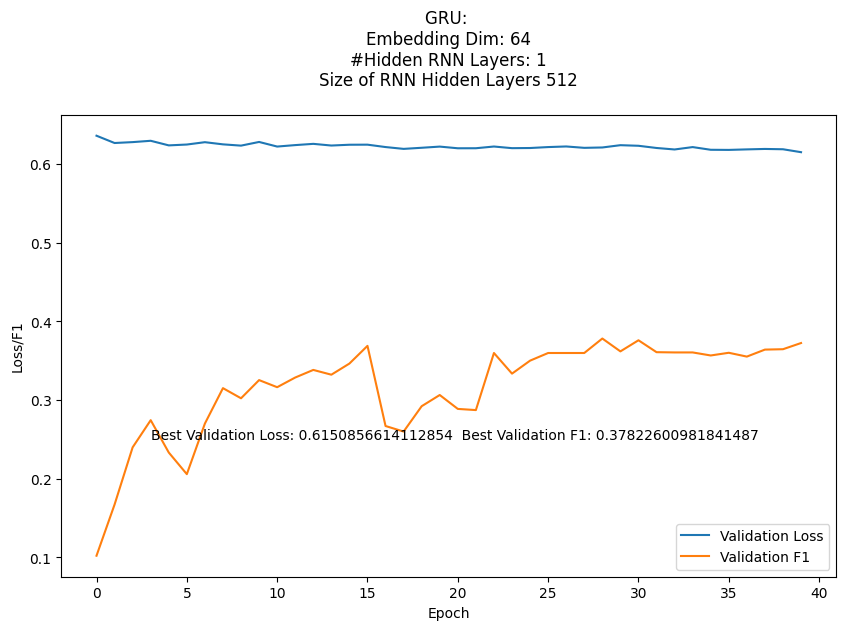

In [98]:
title = (f"GRU: \nEmbedding Dim: {embedding_dim}\n"
f"#Hidden RNN Layers: {num_layers}\n"
f"Size of RNN Hidden Layers {hidden_size}\n")
plot_vals(output_data[output_data['run'] == run_num], title, result_text)

# Conclusion
I suspect that my transition to Pytorch for this project is a large casue of why I wasn't able to get any improvement.

In [ ]:
test = pd.read_csv(test_path, header = 0)
model = Tweets(vocab_size = best_model_params["vocab_size"], 
                                 embedding_dim = best_model_params["embedding_dim"],
                                 hidden_size = best_model_params["hidden_size"], 
                                 num_layers = best_model_params["num_layers"],
                                 nonlinearity = best_model_params["nonlinearity"])
model.load_state_dict(torch.load('best_model.model'))
model.eval()  # Set the model to evaluation mode
